## Image classification with Convolutional Neural Networks

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Here we import the libraries we need. We'll learn about what each does during the course.

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [7]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

`PATH` is the path to your data - if you use the recommended setup approaches from the lesson, you won't need to change this. `sz` is the size that the images will be resized to in order to ensure that the training runs quickly. We'll be talking about this parameter a lot during the course. Leave it at `224` for now.

In [37]:
# PATH = "/local_scratch/wamsterd/data/lidc/nodules2D/"
HOME_PATH = "/home/wamsterd/github/lidc-binary-classification/"
DATA_FOLDER = "data/"
DATA_PATH = "/local_scratch/wamsterd/data/lidc/nodules2D-unsorted/"
LABEL_PATH = "/home/wamsterd/github/lidc-binary-classification/resources/nodule_df.csv"

sz=224

## Import labels

In [47]:
# print(os.listdir(PATH)[:5])

In [58]:
label_df = pd.read_csv(LABEL_PATH, index_col=None)
label_df["filename"] = ["%06d.png" % x for x in label_df.nodule_idx]
label_df["label"] = np.int0(label_df.malignant)
# label_df.head()

print(label_df.shape)
label_df = label_df[label_df['filename'].isin(os.listdir(DATA_PATH))]
print(label_df.shape)

CSV_PATH = os.path.join(HOME_PATH, "resources", "labels.csv")
label_df[["filename", "label"]].to_csv(CSV_PATH, index = None)

(2651, 12)
(1246, 12)


## Improving our model

Let's create a new `data` object that includes this augmentation in the transforms.
Set max_zoom to 1, since size is the most important predictor of malignancy

In [60]:
# setup validation set
val_idx = get_cv_idxs(label_df.shape[0], seed = 123)

arch = resnet50
# sz = 224
sz = 299
bs = 128

tfms = tfms_from_model(arch, sz, 
                       aug_tfms=transforms_top_down, 
                       max_zoom=1.0)

data = ImageClassifierData.from_csv(HOME_PATH, "data", os.path.join("resources", "labels.csv"),
                                   tfms = tfms, bs = bs, val_idxs = val_idx)

learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.unfreeze()

/local_scratch/wamsterd/anaconda3/envs/torch/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/local_scratch/wamsterd/anaconda3/envs/torch/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [61]:
# lr=np.array([1e-4,1e-3,1e-2])
# lr=np.array([.5 * 1e-4,.75 * 1e-2,1e-2])
lrs = np.array([1e-2, 1e-1, 1]) * 1e-1

learn.fit(lrs, 4, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                
    0      0.799331   0.53392    0.759036  
    1      0.706113   0.38458    0.823293                
    2      0.616005   0.404994   0.839357                
    3      0.5519     0.75819    0.807229                
    4      0.49051    0.599954   0.811245                
    5      0.446994   0.408542   0.875502                
    6      0.403834   0.360012   0.883534                
    7      0.38285    0.282284   0.907631                
    8      0.353955   0.36169    0.891566                
    9      0.334284   0.489073   0.859438                
    10     0.314982   0.357471   0.875502                
    11     0.293544   0.280229   0.899598                
    12     0.267199   0.22389    0.911647                
    13     0.244037   0.233239   0.903614                
    14     0.225435   0.236989   0.907631                



[0.23698897282761264, 0.9076305165827034]

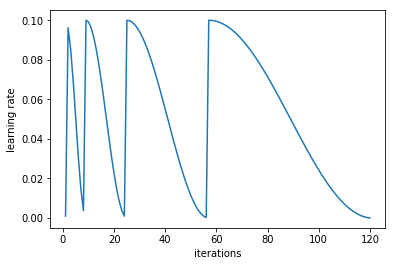

In [62]:
learn.sched.plot_lr()

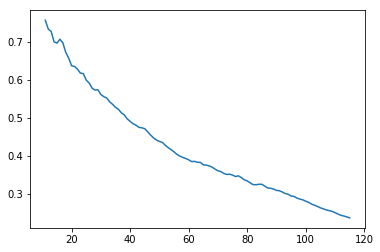

In [63]:
learn.sched.plot_loss()

In [64]:
learn.save('299_all')

In [65]:
learn.load('299_all')

There is something else we can do with data augmentation: use it at *inference* time (also known as *test* time). Not surprisingly, this is known as *test time augmentation*, or just *TTA*.

TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we can use the learner's `TTA()` method.

In [66]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [67]:
accuracy_np(probs, y)

0.9156626506024096

I generally see about a 10-20% reduction in error on this dataset when using TTA at this point, which is an amazing result for such a quick and easy technique!

### Data augmentation visualization

In [42]:
arch = resnet34
tfms = tfms_from_model(arch, sz, 
                       aug_tfms=transforms_top_down, 
                       max_zoom=1.0)

In [43]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
#     data = ImageClassifierData.from_path_and_array(PATH, "heart", 
#                                                y = labels, 
#                                         val_idxs=valid_idx,
#                                        tfms = tfms,
# #                                               classes = ["alive", "deceased"]
#                                                   )
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [44]:
ims = np.stack([get_augs() for i in range(6)])

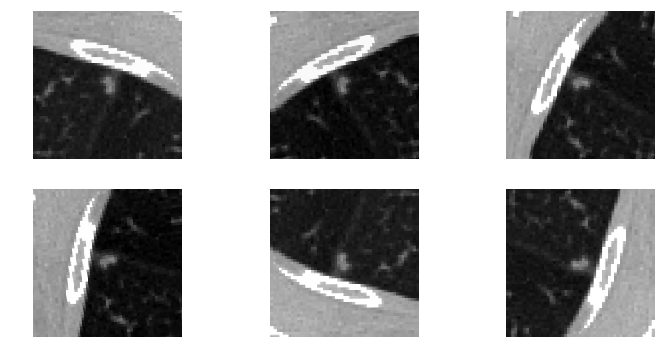

In [45]:
plots(ims, rows=2)

It's important that you have a working NVidia GPU set up. The programming framework used to behind the scenes to work with NVidia GPUs is called CUDA. Therefore, you need to ensure the following line returns `True` before you proceed. If you have problems with this, please check the FAQ and ask for help on [the forums](http://forums.fast.ai).

In [5]:
torch.cuda.is_available()

True

In addition, NVidia provides special accelerated functions for deep learning in a package called CuDNN. Although not strictly necessary, it will improve training performance significantly, and is included by default in all supported fastai configurations. Therefore, if the following does not return `True`, you may want to look into why.

In [6]:
torch.backends.cudnn.enabled

True

### Extra steps if NOT using Crestle or Paperspace or our scripts

The dataset is available at http://files.fast.ai/data/dogscats.zip. You can download it directly on your server by running the following line in your terminal. `wget http://files.fast.ai/data/dogscats.zip`. You should put the data in a subdirectory of this notebook's directory, called `data/`. Note that this data is already available in Crestle and the Paperspace fast.ai template.

### Extra steps if using Crestle

Crestle has the datasets required for fast.ai in /datasets, so we'll create symlinks to the data we want for this competition. (NB: we can't write to /datasets, but we need a place to store temporary files, so we create our own writable directory to put the symlinks in, and we also take advantage of Crestle's `/cache/` faster temporary storage space.)

To run these commands (**which you should only do if using Crestle**) remove the `#` characters from the start of each line.

In [6]:
# os.makedirs('data/dogscats/models', exist_ok=True)

# !ln -s /datasets/fast.ai/dogscats/train {PATH}
# !ln -s /datasets/fast.ai/dogscats/test {PATH}
# !ln -s /datasets/fast.ai/dogscats/valid {PATH}

# os.makedirs('/cache/tmp', exist_ok=True)
# !ln -fs /cache/tmp {PATH}

In [6]:
# os.makedirs('/cache/tmp', exist_ok=True)
# !ln -fs /cache/tmp {PATH}

## First look at cat pictures

Our library will assume that you have *train* and *valid* directories. It also assumes that each dir will have subdirs for each class you wish to recognize (in this case, 'cats' and 'dogs').

In [134]:
os.listdir(PATH)[:10]

['057706_array.npy',
 '044503_array.npy',
 '096109_array.npy',
 '000601_array.npy',
 '073304_array.npy',
 '070104_array.npy',
 '019901_array.npy',
 '040601_array.npy',
 '046605_array.npy',
 '070704_array.npy']

In [133]:
os.listdir(f'{PATH}valid')
# os.listdir(f'{PATH}heart-stack')

FileNotFoundError: [Errno 2] No such file or directory: '/local_scratch/wamsterd/data/lidc/nodules-unsorted/valid'

## Our first model: quick start

We're going to use a <b>pre-trained</b> model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision. We'll be learning all about CNNs during this course.

We will be using the <b>resnet34</b> model. resnet34 is a version of the model that won the 2015 ImageNet competition. Here is more info on [resnet models](https://github.com/KaimingHe/deep-residual-networks). We'll be studying them in depth later, but for now we'll focus on using them effectively.

Here's how to train and evalulate a *dogs vs cats* model in 3 lines of code, and under 20 seconds:

In [341]:
# Uncomment the below if you need to reset your precomputed activations
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [7]:
sz = 224
# sz = img[0] * img[1]
arch = resnet34
data = ImageClassifierData.from_paths(PATH,
                                       tfms = tfms_from_model(arch, sz),
#                                               classes = ["alive", "deceased"]
                                              )
learn = ConvLearner.pretrained(arch, data, precompute = True)
# learn.fit(0.01, 10)

/local_scratch/wamsterd/anaconda3/envs/torch/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)
/local_scratch/wamsterd/anaconda3/envs/torch/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [16]:
learn.lr_find()

epoch      trn_loss   val_loss   accuracy                  
    0      2.29661    266.103836 0.686992  



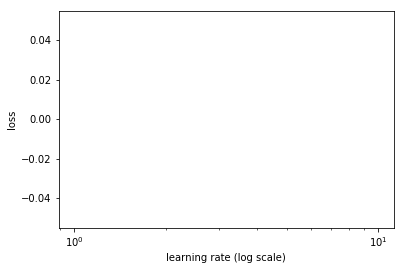

In [17]:
learn.sched.plot()

In [267]:
# arch=resnet34
# data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
# learn = ConvLearner.pretrained(arch, data, precompute=True)
# learn.fit(0.01, 2)

How good is this model? Well, as we mentioned, prior to this competition, the state of the art was 80% accuracy. But the competition resulted in a huge jump to 98.9% accuracy, with the author of a popular deep learning library winning the competition. Extraordinarily, less than 4 years later, we can now beat that result in seconds! Even last year in this same course, our initial model had 98.3% accuracy, which is nearly double the error we're getting just a year later, and that took around 10 minutes to compute.

### get shapes

In [18]:
size_d = {k: PIL.Image.open(PATH + k).size for k in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

(array([  0.,   0.,   0.,   0.,   0., 989.,   0.,   0.,   0.,   0.]),
 array([50.5, 50.6, 50.7, 50.8, 50.9, 51. , 51.1, 51.2, 51.3, 51.4, 51.5]),
 <a list of 10 Patch objects>)

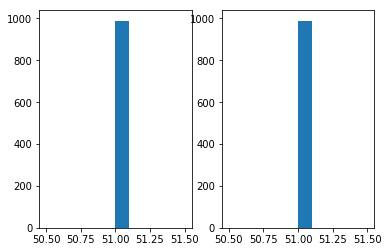

In [19]:
plt.subplot(121)
plt.hist(row_sz)
plt.subplot(122)
plt.hist(col_sz)

Here is how the raw data looks like

In [20]:
img.shape

NameError: name 'img' is not defined

In [180]:
img[:4,:4]

array([[[0.66667, 0.66667, 0.66667],
        [0.66667, 0.66667, 0.66667],
        [0.66667, 0.66667, 0.66667],
        [0.66667, 0.66667, 0.66667]],

       [[0.66667, 0.66667, 0.66667],
        [0.66667, 0.66667, 0.66667],
        [0.66667, 0.66667, 0.66667],
        [0.66667, 0.66667, 0.66667]],

       [[0.66667, 0.66667, 0.66667],
        [0.66667, 0.66667, 0.66667],
        [0.66667, 0.66667, 0.66667],
        [0.66667, 0.66667, 0.66667]],

       [[0.66667, 0.66667, 0.66667],
        [0.66667, 0.66667, 0.66667],
        [0.66667, 0.66667, 0.66667],
        [0.66667, 0.66667, 0.66667]]], dtype=float32)

## Analyzing results: looking at pictures

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (i.e. those with highest probability that are correct)
4. The most incorrect labels of each class (i.e. those with highest probability that are incorrect)
5. The most uncertain labels (i.e. those with probability closest to 0.5).

In [21]:
# This is the label for a val data
data.val_y[:4]

array([0, 0, 0, 0])

In [22]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

['benign', 'malignant']

In [23]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(246, 2)

In [24]:
log_preds[:10]

array([[-0.6858 , -0.70055],
       [-0.5251 , -0.89526],
       [-1.39647, -0.28431],
       [-0.48916, -0.9497 ],
       [-1.30517, -0.31626],
       [-0.43805, -1.03646],
       [-0.64033, -0.74891],
       [-0.27356, -1.42989],
       [-0.69769, -0.68862],
       [-0.62718, -0.76378]], dtype=float32)

In [25]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [26]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [27]:
rand_by_correct(True)

array([184, 143, 191, 146])

In [28]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [29]:
# def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


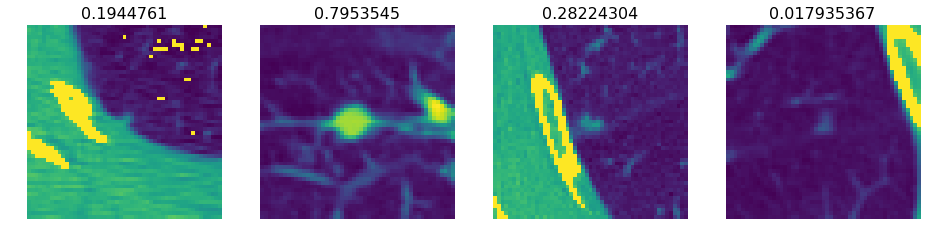

In [112]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


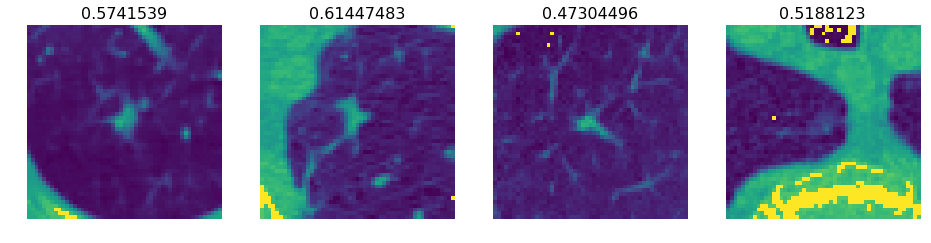

In [113]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [114]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct benign


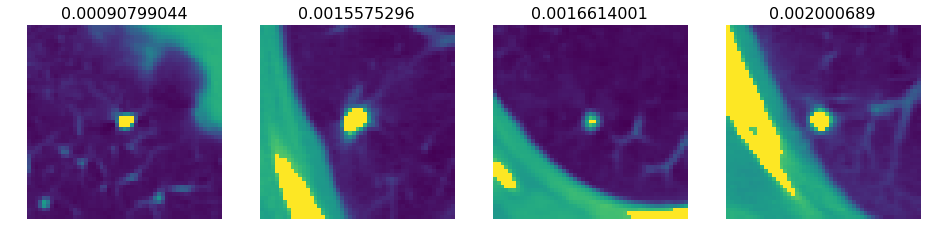

In [115]:
plot_val_with_title(most_by_correct(0, True), "Most correct benign")

Most correct malignant


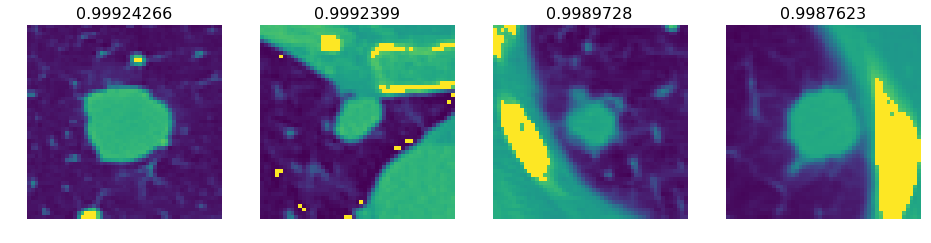

In [116]:
plot_val_with_title(most_by_correct(1, True), "Most correct malignant")

Most incorrect benign


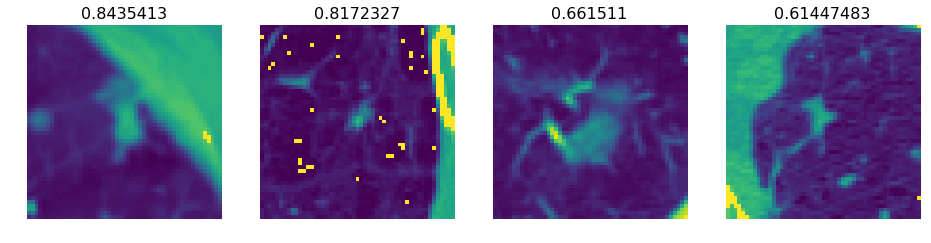

In [117]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect benign")

Most incorrect malignant


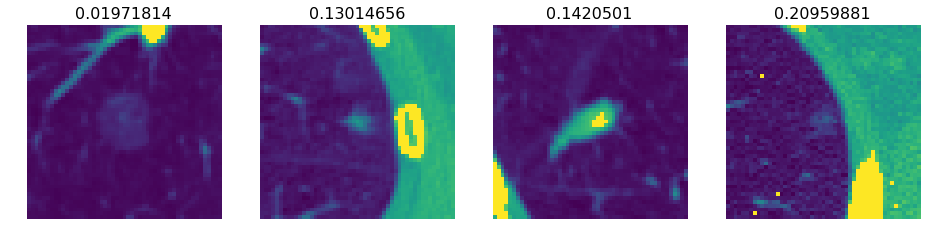

In [118]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect malignant")

Most uncertain predictions


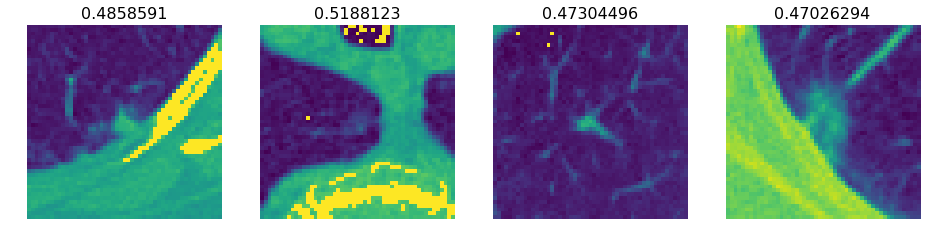

In [119]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Analyzing results

### Confusion matrix 

In [104]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

A common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [105]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[166   6]
 [ 13  61]]


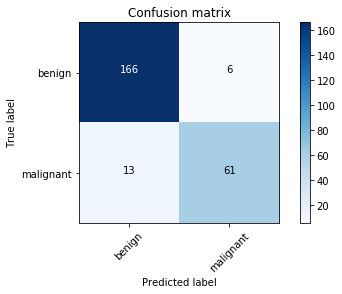

In [122]:
plot_confusion_matrix(cm, data.classes)

### Looking at pictures again

Most incorrect cats


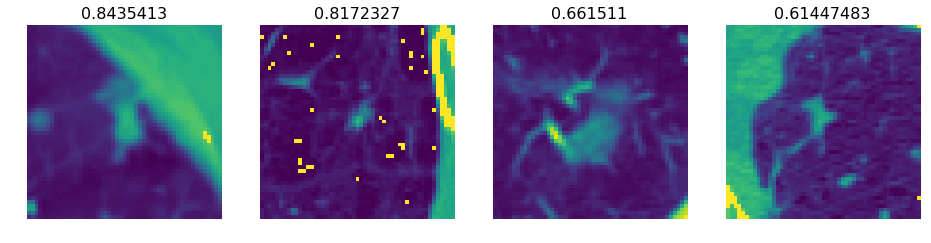

In [123]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


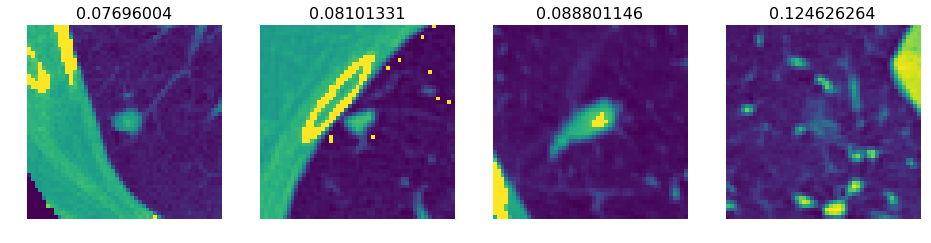

In [70]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

## Review: easy steps to train a world-class image classifier

1. precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting